In [ ]:
!pip install medmnist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from glob import glob
from PIL import Image
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical, plot_model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from medmnist import DermaMNIST

**Load DermaMNIST Dataset**

In [3]:
train_data = DermaMNIST(split="train", download=True)
val_data = DermaMNIST(split="val", download=True)
test_data = DermaMNIST(split="test", download=True)

100%|██████████| 19725078/19725078 [00:36<00:00, 546675.47it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [4]:
x_train, y_train = train_data.imgs, train_data.labels
x_test, y_test = test_data.imgs, test_data.labels
x_val, y_val = val_data.imgs, val_data.labels

train_y = y_train
test_y = y_test
val_y = y_val

train_y=to_categorical(train_y, num_classes=7)
test_y=to_categorical(test_y, num_classes=7)
val_y=to_categorical(val_y, num_classes=7)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_val = y_val.reshape(-1)

# Ensure data type is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# Resize the image from 28x28 -> to 96x96
x_train = tf.image.resize(x_train, (96, 96))
x_val = tf.image.resize(x_val, (96, 96))
x_test = tf.image.resize(x_test, (96, 96))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (7007, 96, 96, 3) - y_train shape: (7007,)
x_val shape: (1003, 96, 96, 3) - y_val shape: (1003,)
x_test shape: (2005, 96, 96, 3) - y_test shape: (2005,)


In [64]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_shape = (96, 96, 3)
num_classes = 7
input_layer = Input(shape=input_shape)

**Xception Model**

In [8]:
from keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception_model.layers:
    layer.trainable = True

x = xception_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_xception = tf.keras.layers.Dense(7, activation='softmax')(x)

model_xception = Model(inputs=input_layer, outputs=output_xception)

# Compile the model
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)   # Implement early stopping

# Train the model
history_xception = model_xception.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

83683744/83683744 [==============================] - 6s 0us/step
Epoch 1/30
219/219 [==============================] - 60s 131ms/step - loss: 0.8483 - accuracy: 0.7050 - val_loss: 0.7261 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - 24s 111ms/step - loss: 0.6973 - accuracy: 0.7433 - val_loss: 0.6949 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - 24s 108ms/step - loss: 0.6009 - accuracy: 0.7811 - val_loss: 0.7542 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - 24s 108ms/step - loss: 0.5251 - accuracy: 0.8082 - val_loss: 0.8501 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - 24s 109ms/step - loss: 0.4204 - accuracy: 0.8476 - val_loss: 0.9938 - val_accuracy: 0.7069 - lr: 0.0010
Epoch 6/30
219/219 [==============================] - 23s 107ms/step - loss: 0.3639 - accuracy: 0.8737 - val_loss: 0.9822 - val_accuracy: 0.6680 

**InceptionResNetV2 Model**

In [9]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet_v2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_resnet_v2_model.layers:
    layer.trainable = True

x = inception_resnet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_inception_resnet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inception_resnet_v2 = Model(inputs=input_layer, outputs=output_inception_resnet_v2)

# Compile the model
model_inception_resnet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)  # Implement early stopping

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

219055592/219055592 [==============================] - 9s 0us/step
Epoch 1/30
219/219 [==============================] - 134s 197ms/step - loss: 0.9451 - accuracy: 0.6893 - val_loss: 1.0045 - val_accuracy: 0.6959 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - 31s 140ms/step - loss: 0.6943 - accuracy: 0.7520 - val_loss: 3.9293 - val_accuracy: 0.6012 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - 31s 140ms/step - loss: 0.5735 - accuracy: 0.7932 - val_loss: 0.6616 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - 31s 142ms/step - loss: 0.5862 - accuracy: 0.7953 - val_loss: 24.1648 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - 31s 140ms/step - loss: 0.5926 - accuracy: 0.7824 - val_loss: 8.9382 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 6/30
219/219 [==============================] - 30s 138ms/step - loss: 0.9698 - accuracy: 0.7124 - val_loss: 1.0591 - val_accuracy: 0.6

**MobileNetV2 Model**

In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in mobilenet_v2_model.layers:
    layer.trainable = True

x = mobilenet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output_mobilenet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_mobilenet_v2 = Model(inputs=input_layer, outputs=output_mobilenet_v2)

# Compile the model
model_mobilenet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)  # Implement early stopping

# Train the model
history_mobilenet_v2 = model_mobilenet_v2.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
219/219 [==============================] - 33s 46ms/step - loss: 0.9316 - accuracy: 0.6819 - val_loss: 12.6257 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - 9s 42ms/step - loss: 0.8247 - accuracy: 0.7080 - val_loss: 8.5929 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - 9s 42ms/step - loss: 0.7601 - accuracy: 0.7283 - val_loss: 5.0891 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - 9s 39ms/step - loss: 0.6981 - accuracy: 0.7478 - val_loss: 14.8080 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 5/50
219/219 [==============================] - 10s 44ms/step - loss: 0.6652 - accuracy: 0.7544 - val_loss: 13.1608 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 6/50
219/219 [==============================] - 10s 44ms/step - loss: 0.6450 - accuracy: 0.7682 - val_loss: 10.0370 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 7/50
219/219 [==============================] - 10s

**GradCAM Analysis**

In [12]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str

    Returns
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):

    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

**View all Convolution Layers of the 3 models**

In [24]:
xception_conv2D_layers = [layer.name for layer in reversed(xception_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
inception_resnet_v2_conv2D_layers = [layer.name for layer in reversed(inception_resnet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
mobilenet_v2_conv2D_layers = [layer.name for layer in reversed(mobilenet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]

print(xception_conv2D_layers)
print(inception_resnet_v2_conv2D_layers)
print(mobilenet_v2_conv2D_layers)

['conv2d_3', 'conv2d_2', 'conv2d_1', 'conv2d', 'block1_conv2', 'block1_conv1']
['conv_7b', 'block8_10_conv', 'conv2d_206', 'conv2d_203', 'conv2d_205', 'conv2d_204', 'block8_9_conv', 'conv2d_202', 'conv2d_199', 'conv2d_201', 'conv2d_200', 'block8_8_conv', 'conv2d_198', 'conv2d_195', 'conv2d_197', 'conv2d_196', 'block8_7_conv', 'conv2d_194', 'conv2d_191', 'conv2d_193', 'conv2d_192', 'block8_6_conv', 'conv2d_190', 'conv2d_187', 'conv2d_189', 'conv2d_188', 'block8_5_conv', 'conv2d_186', 'conv2d_183', 'conv2d_185', 'conv2d_184', 'block8_4_conv', 'conv2d_182', 'conv2d_179', 'conv2d_181', 'conv2d_180', 'block8_3_conv', 'conv2d_178', 'conv2d_175', 'conv2d_177', 'conv2d_176', 'block8_2_conv', 'conv2d_174', 'conv2d_171', 'conv2d_173', 'conv2d_172', 'block8_1_conv', 'conv2d_170', 'conv2d_167', 'conv2d_169', 'conv2d_168', 'conv2d_166', 'conv2d_163', 'conv2d_161', 'conv2d_165', 'conv2d_162', 'conv2d_160', 'conv2d_164', 'block17_20_conv', 'conv2d_159', 'conv2d_156', 'conv2d_158', 'conv2d_157', 'bloc

In [60]:
# Function to visualize grad-cam for multiple indices of test dataset
def visualize_grad_cam_for_indices(model, images, labels, indices, layer_name):
    """
    Generate and visualize Grad-CAM heatmaps for multiple images and a specified layer.

    Args:
        model: Keras model.
        images: List or array of image data.
        labels: List or array of ground truth labels corresponding to the images.
        indices: Array of indices of the images to visualize.
        layer_name: Name of the layer for which Grad-CAM heatmaps will be generated.
    """
    plt.figure(figsize=(5 * len(indices), 5))

    for i, index in enumerate(indices):
        img = images[index]
        label = labels[index]

        grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer_name)
        grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)

        ax = plt.subplot(1, len(indices), i + 1)
        plt.imshow(grad_cam_superimposed)
        plt.axis('off')
        plt.title(f'{classes[label]} ({layer_name})', fontsize=16)

    plt.tight_layout()
    plt.show()


# Function to display original images for multiple indices of test dataset
def show_images_by_indices(images, labels, indices):
    """
    Display images from an array of images based on specified indices.

    Args:
        images: List or array of image data.
        indices: Array of indices of the images to display.
    """
    num_images = len(indices)
    plt.figure(figsize=(5*len(indices), 5))

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(classes[labels[idx]], fontsize=16)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**Grad-CAM Visualization of Xception Model**

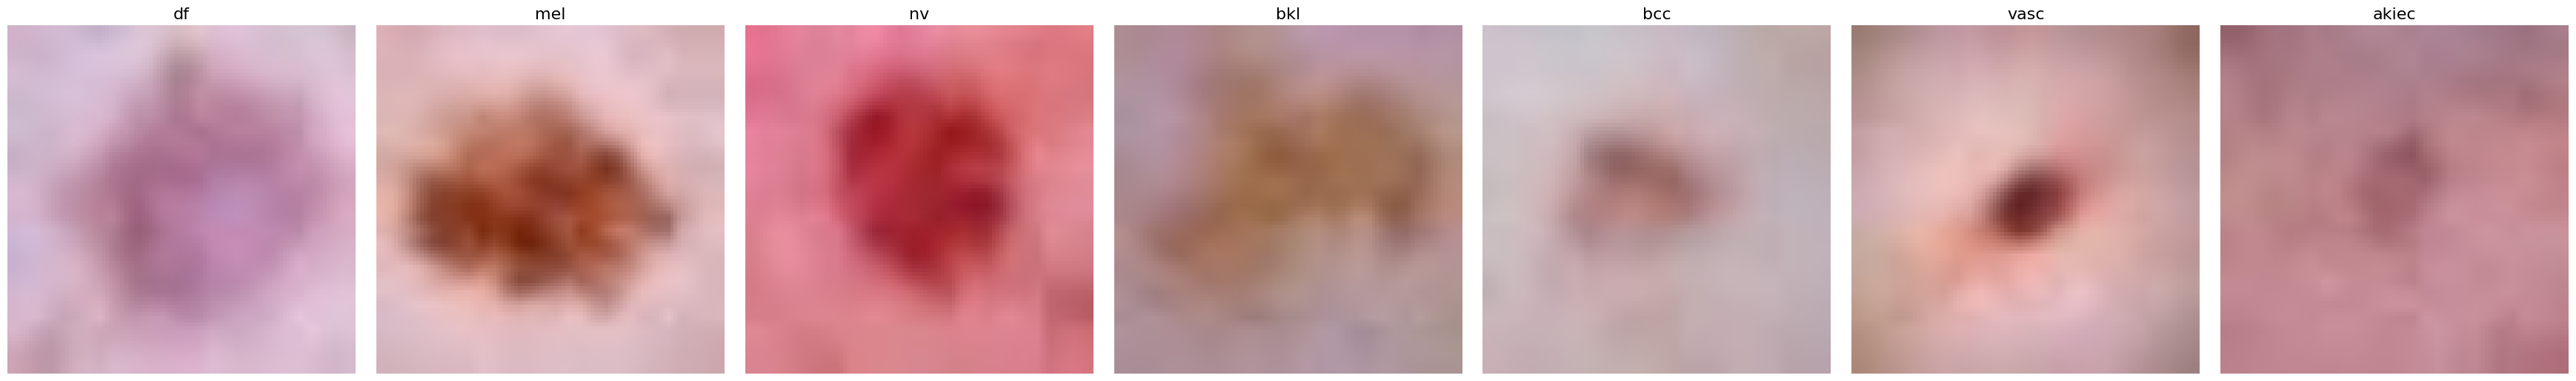

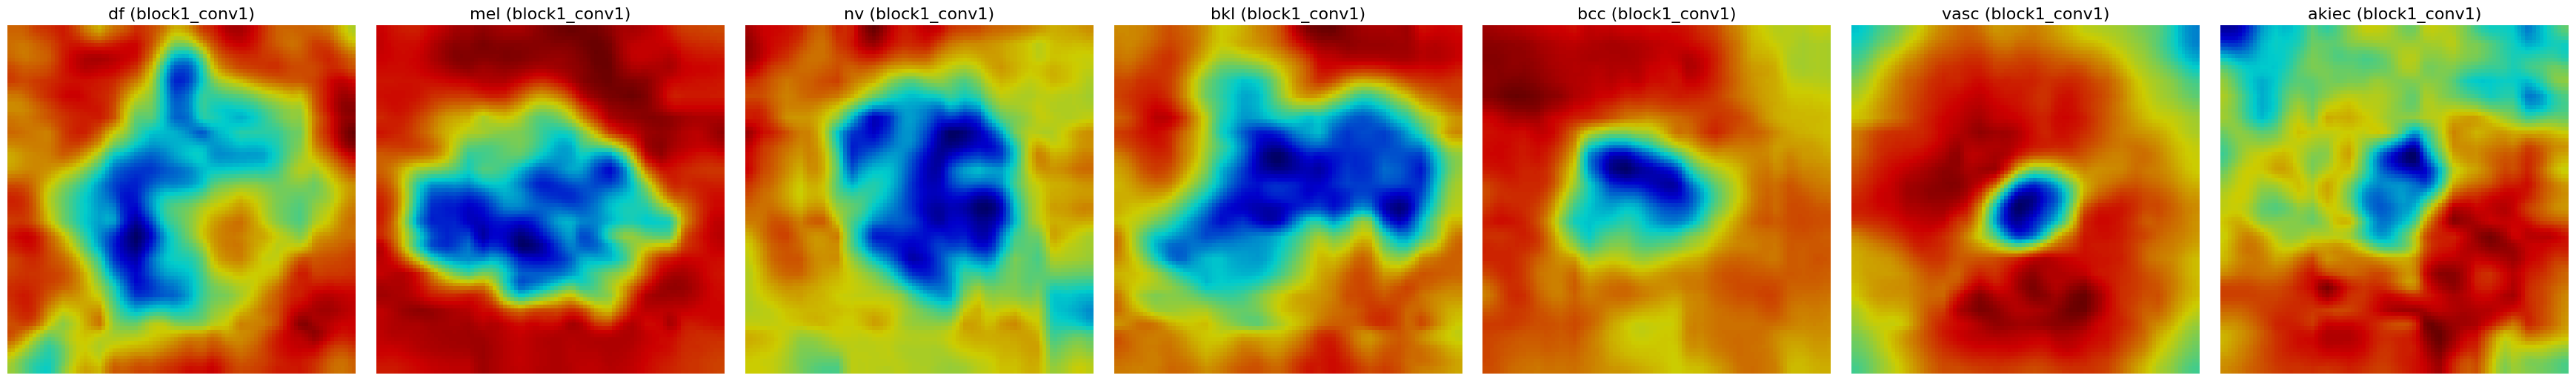

In [61]:
show_images_by_indices(x_test, y_test, [1,7,5,17,10,175,3])
visualize_grad_cam_for_indices(xception_model, x_test, y_test, [1,7,5,17,10,175,3], 'block1_conv1')

**Grad-CAM Visualization of InceptionResNetV2 Model**

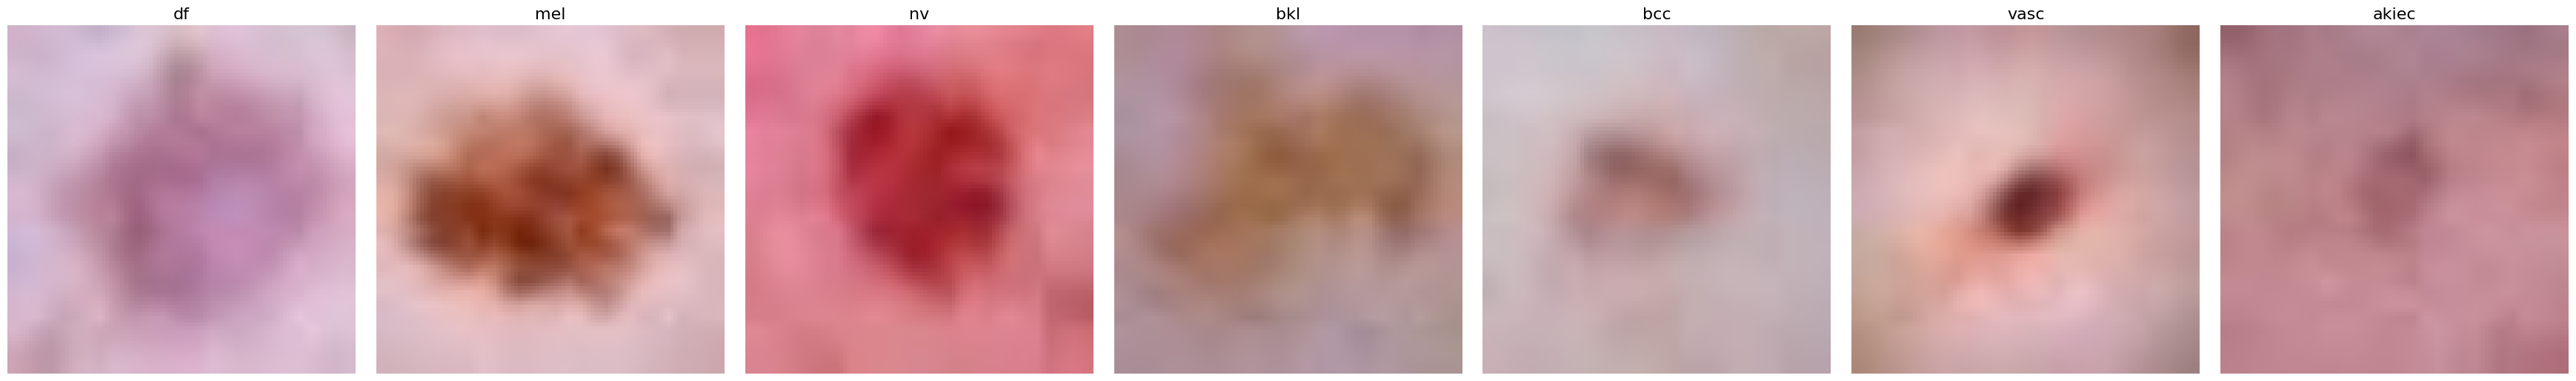

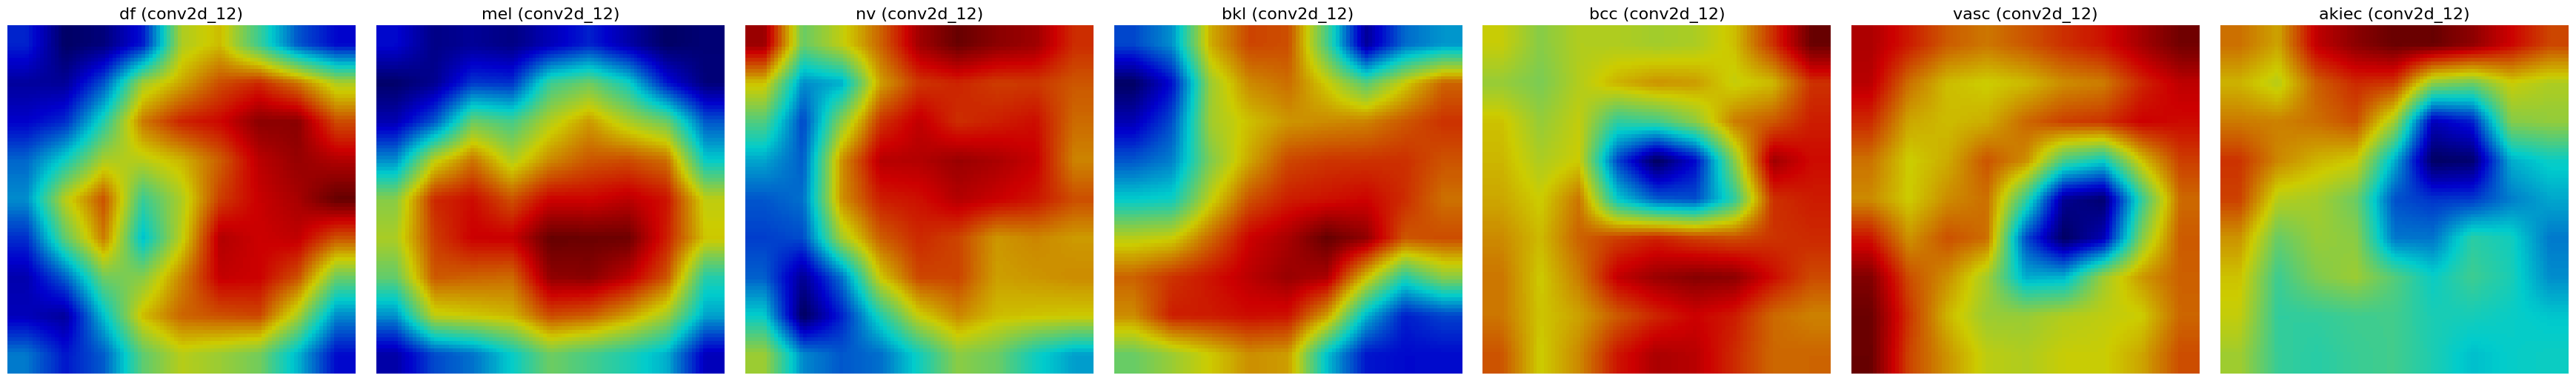

In [62]:
show_images_by_indices(x_test, y_test, [1,7,5,17,10,175,3])
visualize_grad_cam_for_indices(inception_resnet_v2_model, x_test, y_test, [1,7,5,17,10,175,3], 'conv2d_12')

**Grad-CAM Visualization of MobileNetV2 Model**

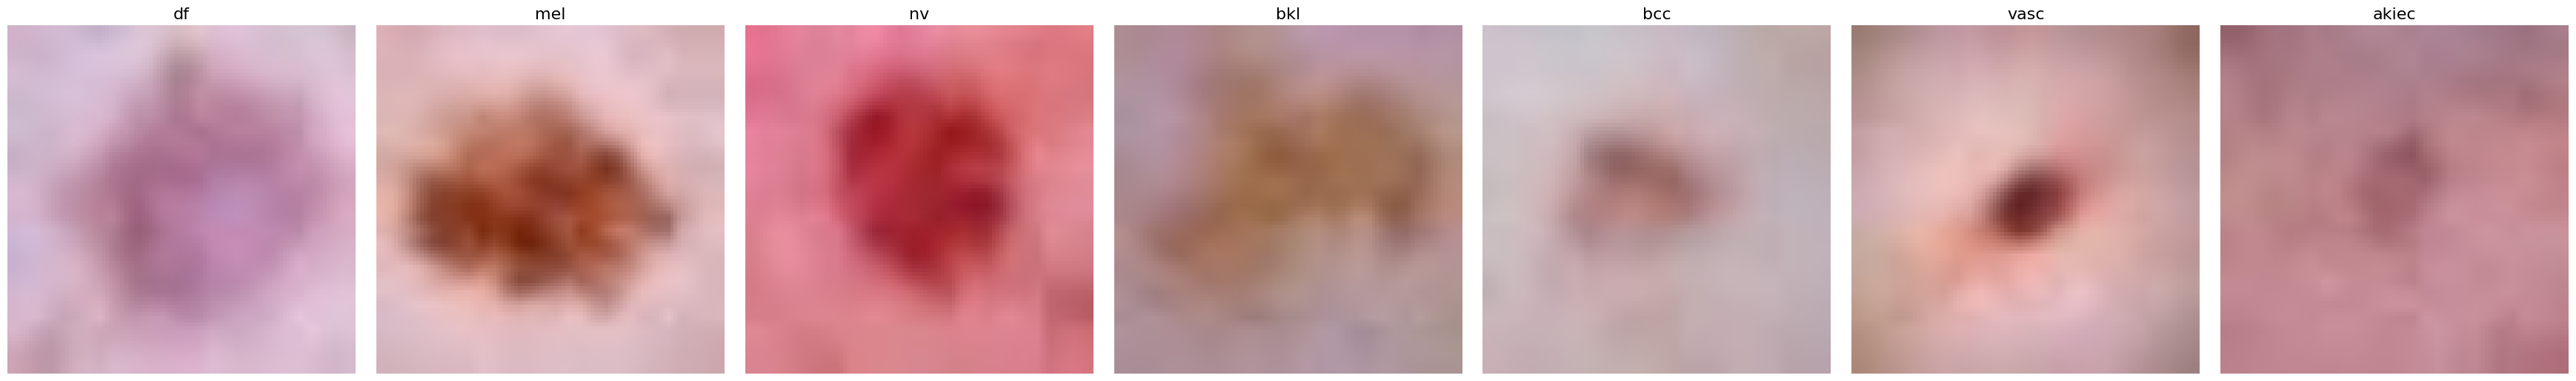

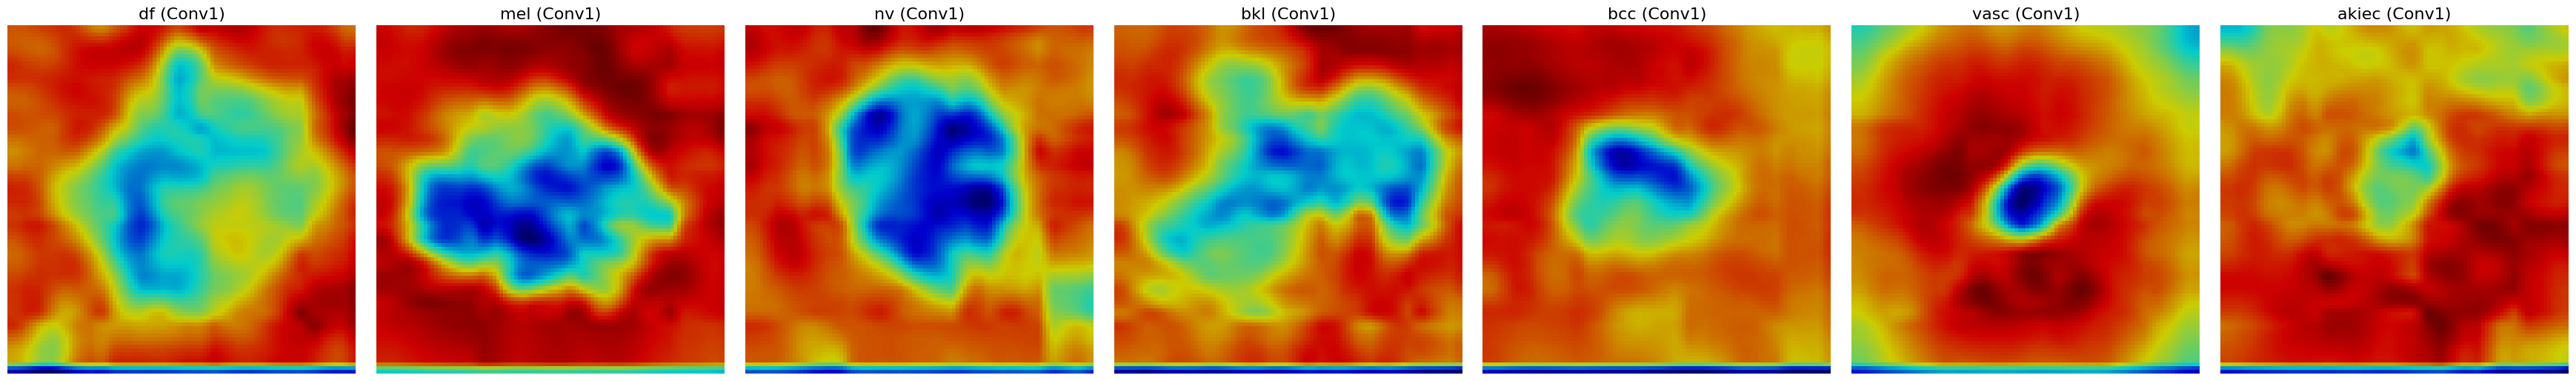

In [63]:
show_images_by_indices(x_test, y_test, [1,7,5,17,10,175,3])
visualize_grad_cam_for_indices(mobilenet_v2_model, x_test, y_test, [1,7,5,17,10,175,3], 'Conv1')